# AIES RL Project

# Salar Hosseiny Shamchi 9805884


#### Defining the environment for the mountain car problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


VALID_ACTIONS = [0, 1, 2]


class MountainCar:
    def __init__(self, mass=0.2, friction=0.3, delta_t=0.1, noise=0):
        """ Create a new mountain car object.

        :param mass: Mass of the car (default 0.2)
        :param friction:  The friction in Newtons (default 0.3)
        :param delta_t: The time step in seconds (default 0.1)
        :param noise: The amount of noise in taking actions
        """
        self.position_list = list()
        self.gravity = 9.81
        self.friction = friction
        self.delta_t = delta_t
        self.mass = mass
        self.position_t1 = -0.5
        self.velocity_t1 = 0.0
        self.noise = noise

    def reset(self, exploring=True, initial_position=-0.5, initial_velocity=0.0):
        """ Resets the car to an initial position in the interval of [-1.2, 0.5]
        
        :param exploring: If True, a random initial position is taken
        :param initial_position: The initial position of the car (requires exploring=False)
        :param initial_velocity: The initial velocity of the car (requires exploring=False)
        :return: The initial position and velocity of the car
        """
        if exploring:
            initial_position = np.random.uniform(-1.2, 0.5)
            initial_velocity = np.random.uniform(-1.5, 1.5)
        elif initial_position < -1.2:
            initial_position = -1.2
        elif initial_position > 0.5:
            initial_position = 0.5
        if initial_velocity > 1.5:
            initial_velocity = 1.5
        elif initial_velocity < -1.5:
            initial_velocity = -1.5
        self.position_list = []  # Clear the list
        self.position_t1 = initial_position
        self.velocity_t1 = initial_velocity
        self.position_list.append(initial_position)
        return [self.position_t1, self.velocity_t1]

    def step(self, action_index):
        """ Take one step in the environment following the given action.
        
        :param action_index: An integer representing one of three actions [0, 1, 2]
                             where 0=move_left, 1=do_not_move, 2=move_right
        :return: (position_t2, velocity_t2), reward, done:
                 Where reward is always negative except when the goal is reached
                 done is True when the goal is reached
        """
        if action_index not in VALID_ACTIONS:
            raise ValueError("[MOUNTAIN CAR][ERROR] The action value "
                             + str(action_index) + " is out of range.")
        done = False
        action_list = [-0.2, 0, 0.2]
        if np.random.random() > self.noise:
            action = action_list[action_index]
        else:
            action = np.random.choice(action_list)
        velocity_t2 = self.velocity_t1 + \
            (-self.gravity * self.mass * np.cos(3 * self.position_t1)
                + (action / self.mass) - (self.friction * self.velocity_t1)) * self.delta_t
        position_t2 = self.position_t1 + (velocity_t2 * self.delta_t)
        reward = - 0.01
        # Check the limit conditions for position
        if position_t2 < -1.2:
            position_t2 = -1.2
            velocity_t2 = 0
        # Reward and done when the car reaches the goal
        elif position_t2 >= 0.5:
            position_t2 = 0.5
            reward = 1
            done = True
        # Check the limit conditions for velocity
        if velocity_t2 < -1.5:
            velocity_t2 = -1.5
        elif velocity_t2 > 1.5:
            velocity_t2 = 1.5
        # Assign the new position_t2 and velocity_t2
        self.position_t1 = position_t2
        self.velocity_t1 = velocity_t2
        self.position_list.append(position_t2)
        # Return state_t2, reward, done
        return reward, [position_t2, velocity_t2], done

    def render(self, file_path='./mountain_car.gif'):
        """ Saves an animation of what happened until that point in the episode.
        Ideally it should be called at the end of the episode.

        :param file_path: the name and path of the video file
        :return: An animation file of the mountain car
        """
        # Plot init
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.2, 0.5), ylim=(-1.1, 1.1))
        ax.grid(False)  # disable the grid
        x_sin = np.linspace(start=-1.2, stop=0.5, num=100)
        y_sin = np.sin(3 * x_sin)
        # plt.plot(x, y)
        ax.plot(x_sin, y_sin)  # plot the sine wave
        dot, = ax.plot([], [], 'ro')
        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
        _position_list = self.position_list
        _delta_t = self.delta_t

        def _init():
            dot.set_data([], [])
            time_text.set_text('')
            return dot, time_text

        def _animate(i):
            x = _position_list[i]
            y = np.sin(3 * x)
            dot.set_data(x, y)
            time_text.set_text("Time: " + str(np.round(i * _delta_t, 1)) + "s" + '\n' + "Frame: " + str(i))
            return dot, time_text

        ani = animation.FuncAnimation(fig, _animate, np.arange(1, len(self.position_list)),
                                      blit=True, init_func=_init, repeat=False)
        ani.save(file_path, fps=int(1 / self.delta_t))
        # # Clear the figure
        # fig.clear()
        # plt.close(fig)


print('Environment loaded.')

Environment loaded.


#### Defining auxiliary functions and constant values for both Q-learning and SARSA algorithms

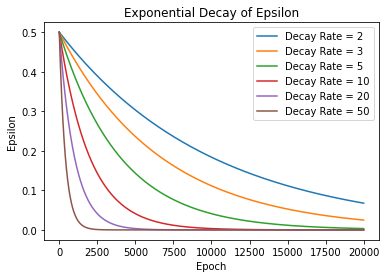

Necessary functions loaded.


In [34]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def discretize(observation):
    position = int((observation[0] + 1.2) * 10)
    velocity = int((observation[1] + 1.5) * 2)
    return position, velocity


def update_state_action(state_action_matrix, observation, new_observation, action, reward, alpha, gamma, new_action=None):
    """
    Returns the updated utility matrix containing the q values for
    each (state, action) pair.

    :param state_action_matrix: The matrix before the update
    :param observation: The state observed at t
    :param new_observation: The state observed at t+1
    :param action: The action taken at t
    :param new_action: The action taken at t+1
    :param reward: The reward observed after taking the action
    :param alpha: Learning rate
    :param gamma: Discount factor
    :return: The updated state action matrix
    """

    action = int(action)
    # Discretizing the states
    position, velocity = discretize(observation)
    new_position, new_velocity = discretize(new_observation)

    # Getting the values of Q at t and at t+1
    q = state_action_matrix[action, position, velocity]
    if new_action == None:
        q_t1 = np.max(state_action_matrix[:, new_position, new_velocity])
    else:
        new_action = int(new_action)
        q_t1 = state_action_matrix[new_action, new_position, new_velocity]

    # Using the Bellman equation to update the Q-values
    state_action_matrix[action, position, velocity] = q + alpha * (reward + gamma * q_t1 - q)
    return state_action_matrix


def update_policy(policy_matrix, state_action_matrix, observation):
    """
    Returns the updated policy matrix by choosing the best action
    for each state based on Q-values.

    :param policy_matrix: Policy matrix before the update
    :param state_action_matrix:: The state-action matrix containing
    Q-values
    :param observation: The state observed at t
    :return: The updated state action matrix
    """
    # Discretizing the states
    position, velocity = discretize(observation)

    # Choosing the best action for current state based on Q-values
    best_action = np.argmax(state_action_matrix[:, position, velocity])
    # Updating the policy
    policy_matrix[position, velocity] = best_action
    return policy_matrix


def return_epsilon_greedy_action(policy_matrix, observation, epsilon=0.1):
    """
    Returns either the best action for the current state by the policy
    matrix, or a random action based on the probability determined by
    epsilon.
    :param policy_matrix: The policy which determines the best action
    for the current state.
    :param observation: The current state
    :param epsilon: The probability of taking a random action
    :return: The action for the current state
    """
    if random.uniform(0, 1) >= epsilon:
        position, velocity = discretize(observation)
        action = policy_matrix[position, velocity]
    else:
        action = random.randint(VA[0], VA[-1])

    return action


def return_decayed_value(starting_value, current_step, tot_steps, decay_rate=10):
    """
    Returns the decaying value for the current step based on exponential decay.
    decayed_value = starting_value * ( 1 - (decay_rate/total_steps)) ^ current_step

    :param starting_value: The value before decaying
    :param current_step: The current step to use for decay (positive integer)
    :param tot_steps: the total number of steps
    :param decay_rate: The exponential rate at which the starting value decays
    """
    if tot_steps < decay_rate:
        raise Exception('Minimum number of total epochs =', decay_rate + 1)
    decayed_value = starting_value * np.power(1 - (decay_rate / tot_steps), current_step)
    return decayed_value


# The grid size is based on the way of discretizing the states
# (number of possible positional states, number of possible velocity states)
grid_size = (17 + 1, 6 + 1)
mc = MountainCar()
VA = VALID_ACTIONS

# Discount factor
gamma = 0.999
# Learning rate
alpha = 0.1
# Number of epochs and the frequency of printing training data
tot_epoch = 20000
print_epoch = 2000
# Number of steps in each epoch (episode length)
epoch_steps = 50
# Initial value for epsilon
epsilon_i = 0.5

plt.figure()
for decay_rate in [2, 3, 5, 10, 20, 50]:
    epsilon = []
    for epoch in range(tot_epoch):
        epsilon.append(return_decayed_value(epsilon_i, epoch, tot_epoch, decay_rate))

    plt.plot(range(tot_epoch), epsilon)
plt.legend(['Decay Rate = 2', 'Decay Rate = 3', 'Decay Rate = 5', "Decay Rate = 10", "Decay Rate = 20", "Decay Rate = 50"])
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.title("Exponential Decay of Epsilon")
plt.show()

print('Necessary functions loaded.')

#### Q-learning


Epsilon: 0.5
Policy matrix after 1 iterations:
[[1 2 2 1 0 1 0]
 [1 1 2 2 0 2 2]
 [2 2 1 0 0 2 0]
 [0 2 2 2 2 1 1]
 [0 1 0 2 2 0 0]
 [0 2 1 2 2 1 1]
 [1 0 0 2 2 0 0]
 [2 0 2 2 2 1 1]
 [1 1 2 2 0 0 2]
 [2 2 0 0 0 0 0]
 [0 0 0 0 1 1 0]
 [0 0 2 1 2 2 2]
 [0 1 0 2 0 1 0]
 [0 2 1 1 0 2 1]
 [1 0 2 1 0 1 0]
 [0 0 2 0 0 2 2]
 [2 0 2 0 2 1 2]
 [2 0 0 0 2 2 2]]

Epsilon: 0.1838937260730055
Policy matrix after 2001 iterations:
[[0 0 2 2 1 0 0]
 [2 2 2 2 2 0 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 0 1]
 [2 2 2 2 2 2 0]
 [2 2 1 2 2 1 0]
 [0 0 0 2 2 1 0]
 [0 1 0 2 2 2 2]
 [2 0 0 0 2 2 2]
 [1 1 0 0 2 2 0]
 [2 0 1 2 2 2 0]
 [0 1 0 1 2 2 2]
 [1 1 0 2 2 0 0]
 [2 1 0 2 2 2 1]
 [1 0 0 2 2 0 0]
 [0 1 0 2 2 1 2]
 [2 2 2 2 2 2 2]
 [2 0 0 0 2 2 2]]
Training time for 2000 epochs = 0:00:02.272674

Epsilon: 0.06763380497802716
Policy matrix after 4001 iterations:
[[0 0 2 2 1 2 0]
 [2 2 2 2 2 0 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 0 1]
 [2 2 2 2 2 2 0]
 [2 2 1 2 2 1 0]
 [0 0 0 2 2 2 0]
 [0 1 0 2 2 2 2]
 [2 0 0 0 2 2 2]
 [1 1

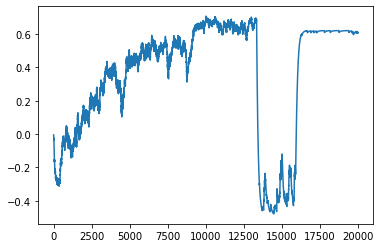

MovieWriter ffmpeg unavailable; using Pillow instead.


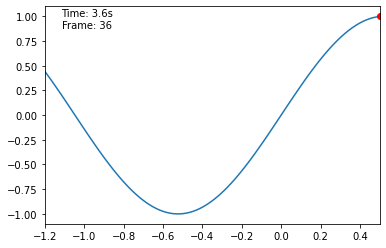

In [37]:
# Random policy
policy_matrix = np.random.randint(low=VA[0], high=VA[-1] + 1, size=grid_size)
# Initializing the Q-values with zeros
state_action_matrix = np.zeros((len(VA), grid_size[0], grid_size[1]))

# Initializing the accumulative return for each epoch with zero
accumulative_return = np.zeros((tot_epoch, 1))
accumulative_return_step = 0
# Tracking the training time
start_total = datetime.now()
start_epoch = datetime.now()

# Training procedure
for epoch in range(tot_epoch):
    # In the last third of the training process, initial state = (0, 0)
    # and the initial action is chosen by the epsilon greedy method.
    if epoch > tot_epoch * 2 / 3:
        observation = mc.reset(exploring=False)
        is_starting = False
        if epoch == tot_epoch - 1:
            epsilon = 0
    # For the rest of the training process, the initial state and action
    # are chosen randomly
    else:
        observation = mc.reset(exploring=True)
        epsilon = return_decayed_value(epsilon_i, epoch, tot_epoch)
        is_starting = True
    # Accumulated reward is set to 0 before each iteration
    accumulated_reward = 0

    for step in range(epoch_steps):
        # The first action of each episode is randomly chosen
        if is_starting:
            action = random.randint(VA[0], VA[-1])
            is_starting = False
        # Take the action using epsilon-greedy
        else:
            action = return_epsilon_greedy_action(policy_matrix, observation, epsilon)
        # Move one step in the environment and get the observation and reward
        reward, new_observation, done = mc.step(action)

        # Updating the state-action matrix
        state_action_matrix = update_state_action(state_action_matrix, observation,
                                                  new_observation, action, reward, alpha, gamma)
        # Updating the policy
        policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)

        # Accumulated reward
        accumulated_reward = accumulated_reward + gamma ** step * reward

        if done:
            break

        observation = new_observation

    if epoch % print_epoch == 0:
        print("")
        print("Epsilon: " + str(epsilon))
        print("Policy matrix after " + str(epoch + 1) + " iterations:")
        print(policy_matrix)
        if epoch != 0:
            end_epoch = datetime.now()
            elapsed_epoch = end_epoch - start_epoch
            print(f'Training time for {print_epoch} epochs =', str(elapsed_epoch))
            start_epoch = datetime.now()

    # Accumulated reward
    accumulative_return_step = (0.99 * accumulative_return_step) + (0.01 * accumulated_reward)
    # Accumulative return for the current epoch = accumulated_reward
    accumulative_return[epoch, 0] = accumulative_return_step

# Final policy matrix
print("Policy matrix after " + str(tot_epoch) + " iterations:")
print(policy_matrix)

# Total training time
end_total = datetime.now()
elapsed_total = end_total - start_total
print('Total training time =', str(elapsed_total))

# Accumulative return
plt.plot(range(tot_epoch), accumulative_return[:, 0])
plt.show()
mc.render(file_path="./q_learning.gif")

# Saving the Q-values, policy matrix and accumulative return in separate files
np.save('Q-Learning_Q-Values', state_action_matrix)
np.save('Q-Learning_Policy', policy_matrix)
np.save('Q-learning', accumulative_return[:, 0])


#### SARSA


Epsilon: 0.5
Policy matrix after 1 iterations:
[[1 1 1 0 2 2 0]
 [1 0 2 2 1 1 2]
 [0 0 1 2 1 1 0]
 [2 2 0 1 0 1 1]
 [0 0 2 0 0 0 1]
 [1 1 1 1 1 0 1]
 [1 1 0 0 1 0 2]
 [2 1 0 1 1 1 2]
 [2 2 0 2 2 0 2]
 [0 1 2 0 0 1 0]
 [1 2 1 0 0 2 2]
 [2 0 2 0 1 0 0]
 [2 1 2 1 1 2 0]
 [1 1 2 1 2 2 0]
 [1 0 1 0 0 0 2]
 [2 1 0 0 1 1 2]
 [0 0 1 0 2 2 1]
 [1 0 0 1 0 2 1]]

Epsilon: 0.1838937260730055
Policy matrix after 2001 iterations:
[[1 2 2 2 1 0 0]
 [1 1 2 2 2 0 2]
 [2 2 2 2 1 0 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1]
 [0 2 0 2 2 1 1]
 [0 2 0 2 2 2 1]
 [1 2 1 2 2 2 1]
 [0 1 0 0 2 2 1]
 [0 0 0 0 2 2 1]
 [1 0 0 0 2 2 2]
 [0 0 0 1 2 2 0]
 [1 2 0 2 2 1 0]
 [0 0 0 2 2 2 0]
 [0 1 0 2 2 1 2]
 [1 0 2 2 2 1 2]
 [0 2 2 2 2 1 1]
 [1 0 0 1 0 2 1]]
Training time for 2000 epochs = 0:00:01.884907

Epsilon: 0.06763380497802716
Policy matrix after 4001 iterations:
[[1 2 2 2 1 0 0]
 [1 2 2 2 2 0 2]
 [2 2 2 1 2 0 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 1 1 1]
 [0 2 0 2 2 2 1]
 [0 2 0 2 2 2 1]
 [1 2 1 2 2 2 1]
 [0 0 0 0 2 2 1]
 [0 0

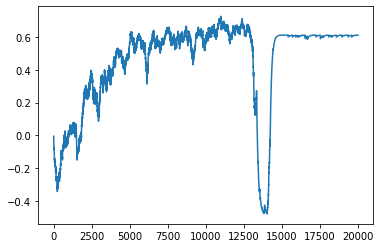

MovieWriter ffmpeg unavailable; using Pillow instead.


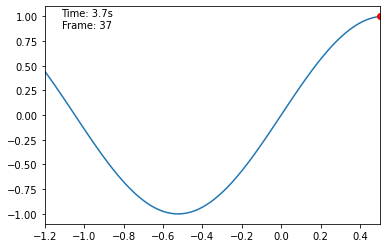

In [44]:
# Random policy
policy_matrix = np.random.randint(low=VA[0], high=VA[-1] + 1, size=grid_size)
# Initializing the Q-values with zeros
state_action_matrix = np.zeros((len(VA), grid_size[0], grid_size[1]))

# Initializing the accumulative return for each epoch with zero
accumulative_return = np.zeros((tot_epoch, 1))
accumulative_return_step = 0
# Tracking the training time
start_total = datetime.now()
start_epoch = datetime.now()

# Training procedure
for epoch in range(tot_epoch):
    # In the last third of the training process, initial state = (0, 0)
    # and the initial action is chosen by the epsilon greedy method.
    if epoch > tot_epoch * 2 / 3:
        observation = mc.reset(exploring=False)
        is_starting = False
        if epoch == tot_epoch - 1:
            epsilon = 0
    # For the rest of the training process, the initial state and action
    # are chosen randomly
    else:
        observation = mc.reset(exploring=True)
        epsilon = return_decayed_value(epsilon_i, epoch, tot_epoch)
        is_starting = True
    # Accumulated reward is set to 0 before each iteration
    accumulated_reward = 0

    for step in range(epoch_steps):
        # The first action of each episode is randomly chosen
        if is_starting:
            action = random.randint(VA[0], VA[-1])
            is_starting = False
        # Take the action using epsilon-greedy
        else:
            action = return_epsilon_greedy_action(policy_matrix, observation, epsilon)
        # Move one step in the environment and get the observation and reward
        reward, new_observation, done = mc.step(action)

        # Determining the new action based on the policy
        new_position, new_velocity = discretize(new_observation)
        new_action = policy_matrix[new_position, new_velocity]

        # Updating the state-action matrix
        state_action_matrix = update_state_action(state_action_matrix, observation, new_observation,
                                                  action, reward, alpha, gamma, new_action)
        # Updating the policy
        policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)

        # Accumulated reward
        accumulated_reward = accumulated_reward + gamma ** step * reward

        if done:
            break

        observation = new_observation

    if epoch % print_epoch == 0:
        print("")
        print("Epsilon: " + str(epsilon))
        print("Policy matrix after " + str(epoch + 1) + " iterations:")
        print(policy_matrix)
        if epoch != 0:
            end_epoch = datetime.now()
            elapsed_epoch = end_epoch - start_epoch
            print(f'Training time for {print_epoch} epochs =', str(elapsed_epoch))
            start_epoch = datetime.now()

    # Accumulated reward
    accumulative_return_step = (0.99 * accumulative_return_step) + (0.01 * accumulated_reward)
    # Accumulative return for the current epoch = accumulated_reward
    accumulative_return[epoch, 0] = accumulative_return_step

# Final policy matrix
print("Policy matrix after " + str(tot_epoch) + " iterations:")
print(policy_matrix)

# Total training time
end_total = datetime.now()
elapsed_total = end_total - start_total
print('Total training time =', str(elapsed_total))

# Accumulative return
plt.plot(range(tot_epoch), accumulative_return[:, 0])
plt.show()
mc.render(file_path="./sarsa.gif")

# Saving the Q-values, policy matrix and accumulative return in separate files
np.save('SARSA_Q-Values', state_action_matrix)
np.save('SARSA_Policy', policy_matrix)
np.save('SARSA', accumulative_return[:, 0])


#### Effect of %20 noise


Epsilon: 1.0
Policy matrix after 1 iterations:
[[0 2 2 0 0 1 2]
 [1 1 2 1 1 2 2]
 [2 2 2 1 1 1 1]
 [2 1 2 0 2 2 2]
 [1 0 0 0 2 0 1]
 [1 0 0 2 0 0 2]
 [1 0 1 1 0 2 1]
 [0 0 0 2 0 2 0]
 [1 0 1 1 2 2 1]
 [1 2 2 0 2 0 0]
 [2 1 0 2 0 0 2]
 [1 1 1 1 1 1 0]
 [2 1 2 2 1 1 1]
 [2 0 1 0 1 0 2]
 [0 2 2 1 1 2 1]
 [2 2 1 0 0 2 0]
 [2 1 2 2 1 1 2]
 [2 1 1 2 1 1 2]]

Epsilon: 0.367787452146011
Policy matrix after 2001 iterations:
[[2 0 1 2 2 0 2]
 [0 2 1 2 2 1 0]
 [0 2 1 2 0 2 0]
 [2 1 1 1 2 2 1]
 [2 2 2 2 2 1 1]
 [0 0 1 2 1 2 1]
 [1 0 0 2 2 2 2]
 [0 0 0 1 2 2 0]
 [0 0 0 1 2 2 2]
 [2 0 0 1 2 1 2]
 [0 0 0 0 2 2 2]
 [1 0 0 0 2 2 0]
 [1 0 0 2 2 2 1]
 [0 0 0 2 2 0 2]
 [0 1 0 2 2 0 1]
 [0 0 2 2 2 0 0]
 [0 1 1 2 2 1 2]
 [2 1 1 2 1 1 2]]
Training time for 2000 epochs = 0:00:04.314510

Epsilon: 0.13526760995605433
Policy matrix after 4001 iterations:
[[2 0 2 2 0 2 2]
 [1 1 2 0 1 0 1]
 [0 2 2 2 2 2 0]
 [2 0 2 2 2 1 2]
 [2 0 2 2 2 2 2]
 [0 2 1 2 2 2 1]
 [0 0 0 2 2 2 2]
 [0 0 0 0 2 2 2]
 [0 1 0 0 2 2 2]
 [1 0 

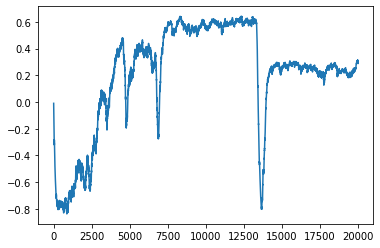

MovieWriter ffmpeg unavailable; using Pillow instead.


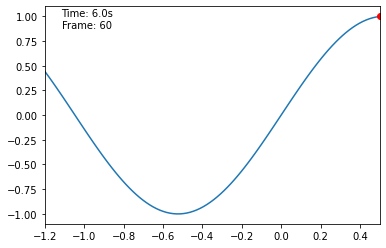

In [21]:
mc = MountainCar(noise=0.2)
# Number of steps in each epoch (episode length)
epoch_steps = 100

# Random policy
policy_matrix = np.random.randint(low=VA[0], high=VA[-1] + 1, size=grid_size)
# Initializing the Q-values with zeros
state_action_matrix = np.zeros((len(VA), grid_size[0], grid_size[1]))

# Initializing the accumulative return for each epoch with zero
accumulative_return = np.zeros((tot_epoch, 1))
accumulative_return_step = 0
# Tracking the training time
start_total = datetime.now()
start_epoch = datetime.now()

# Training procedure
for epoch in range(tot_epoch):
    # In the last third of the training process, initial state = (0, 0)
    # and the initial action is chosen by the epsilon greedy method.
    if epoch > tot_epoch * 2 / 3:
        observation = mc.reset(exploring=False)
        is_starting = False
        if epoch == tot_epoch - 1:
            epsilon = 0
    # For the rest of the training process, the initial state and action
    # are chosen randomly
    else:
        observation = mc.reset(exploring=True)
        epsilon = return_decayed_value(epsilon_i, epoch, tot_epoch)
        is_starting = True
    # Accumulated reward is set to 0 before each iteration
    accumulated_reward = 0

    for step in range(epoch_steps):
        # The first action of each episode is randomly chosen
        if is_starting:
            action = random.randint(VA[0], VA[-1])
            is_starting = False
        # Take the action using epsilon-greedy
        else:
            action = return_epsilon_greedy_action(policy_matrix, observation, epsilon)
        # Move one step in the environment and get the observation and reward
        reward, new_observation, done = mc.step(action)

        # Determining the new action based on the policy
        new_position, new_velocity = discretize(new_observation)
        new_action = policy_matrix[new_position, new_velocity]

        # Updating the state-action matrix
        state_action_matrix = update_state_action(state_action_matrix, observation, new_observation,
                                                  action, reward, alpha, gamma, new_action)
        # Updating the policy
        policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)

        # Accumulated reward
        accumulated_reward = accumulated_reward + gamma ** step * reward

        if done:
            break

        observation = new_observation

    if epoch % print_epoch == 0:
        print("")
        print("Epsilon: " + str(epsilon))
        print("Policy matrix after " + str(epoch + 1) + " iterations:")
        print(policy_matrix)
        if epoch != 0:
            end_epoch = datetime.now()
            elapsed_epoch = end_epoch - start_epoch
            print(f'Training time for {print_epoch} epochs =', str(elapsed_epoch))
            start_epoch = datetime.now()

    # Accumulated reward
    accumulative_return_step = (0.99 * accumulative_return_step) + (0.01 * accumulated_reward)
    # Accumulative return for the current epoch = accumulated_reward
    accumulative_return[epoch, 0] = accumulative_return_step

# Final policy matrix
print("Policy matrix after " + str(tot_epoch) + " iterations:")
print(policy_matrix)

# Total training time
end_total = datetime.now()
elapsed_total = end_total - start_total
print('Total training time =', str(elapsed_total))

# Accumulative return
plt.plot(range(tot_epoch), accumulative_return[:, 0])
plt.show()
mc.render(file_path="./0.2_noisy_sarsa.gif")

# Saving the Q-values, policy matrix and accumulative return in separate files
np.save('0.2_Noisy_Q-Values', state_action_matrix)
np.save('0.2_Noisy_Policy', policy_matrix)
np.save('0.2_Noisy_SARSA', accumulative_return[:, 0])


#### Effect of %30 noise


Epsilon: 1.0
Policy matrix after 1 iterations:
[[0 2 1 1 0 1 2]
 [2 1 1 0 2 0 1]
 [1 1 2 2 0 1 1]
 [1 1 2 0 0 0 0]
 [0 0 1 2 2 0 2]
 [0 2 2 2 0 0 0]
 [0 0 0 2 0 0 2]
 [0 1 2 0 2 0 1]
 [1 0 2 2 1 1 0]
 [2 1 2 0 2 2 0]
 [1 0 2 0 0 1 1]
 [2 2 0 0 0 0 0]
 [1 2 1 1 1 0 1]
 [0 1 2 2 1 2 0]
 [0 1 0 1 1 0 2]
 [2 2 1 2 1 2 1]
 [0 1 1 0 1 0 1]
 [2 0 0 1 1 1 0]]

Epsilon: 0.367787452146011
Policy matrix after 2001 iterations:
[[1 2 0 2 0 0 2]
 [0 1 1 1 2 2 1]
 [1 0 1 2 2 1 1]
 [0 2 1 1 2 1 2]
 [2 2 0 2 1 2 2]
 [0 0 0 2 2 2 2]
 [0 0 0 2 2 2 2]
 [2 0 0 0 2 2 2]
 [1 0 0 0 1 2 1]
 [2 2 0 0 2 2 1]
 [1 1 0 0 2 2 1]
 [0 0 0 0 2 2 0]
 [2 0 0 2 2 1 1]
 [1 0 0 1 2 2 0]
 [1 0 0 2 2 2 2]
 [2 1 0 2 1 0 1]
 [0 1 2 2 0 1 1]
 [2 0 0 1 1 1 0]]
Training time for 2000 epochs = 0:00:04.389702

Epsilon: 0.13526760995605433
Policy matrix after 4001 iterations:
[[2 0 2 1 2 2 2]
 [0 2 2 2 1 1 2]
 [1 1 2 2 2 0 0]
 [2 1 2 1 2 1 0]
 [2 2 1 2 2 2 1]
 [0 0 0 2 2 2 2]
 [2 0 0 2 2 2 2]
 [0 0 0 0 2 2 2]
 [0 1 0 0 2 2 2]
 [2 0 

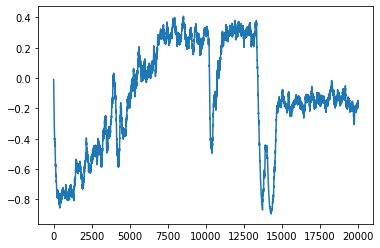

MovieWriter ffmpeg unavailable; using Pillow instead.


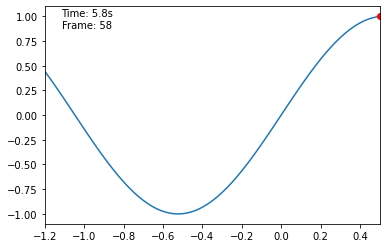

In [22]:
mc = MountainCar(noise=0.3)
# Number of steps in each epoch (episode length)
epoch_steps = 100

# Random policy
policy_matrix = np.random.randint(low=VA[0], high=VA[-1] + 1, size=grid_size)
# Initializing the Q-values with zeros
state_action_matrix = np.zeros((len(VA), grid_size[0], grid_size[1]))

# Initializing the accumulative return for each epoch with zero
accumulative_return = np.zeros((tot_epoch, 1))
accumulative_return_step = 0
# Tracking the training time
start_total = datetime.now()
start_epoch = datetime.now()

# Training procedure
for epoch in range(tot_epoch):
    # In the last third of the training process, initial state = (0, 0)
    # and the initial action is chosen by the epsilon greedy method.
    if epoch > tot_epoch * 2 / 3:
        observation = mc.reset(exploring=False)
        is_starting = False
        if epoch == tot_epoch - 1:
            epsilon = 0
    # For the rest of the training process, the initial state and action
    # are chosen randomly
    else:
        observation = mc.reset(exploring=True)
        epsilon = return_decayed_value(epsilon_i, epoch, tot_epoch)
        is_starting = True
    # Accumulated reward is set to 0 before each iteration
    accumulated_reward = 0

    for step in range(epoch_steps):
        # The first action of each episode is randomly chosen
        if is_starting:
            action = random.randint(VA[0], VA[-1])
            is_starting = False
        # Take the action using epsilon-greedy
        else:
            action = return_epsilon_greedy_action(policy_matrix, observation, epsilon)
        # Move one step in the environment and get the observation and reward
        reward, new_observation, done = mc.step(action)

        # Determining the new action based on the policy
        new_position, new_velocity = discretize(new_observation)
        new_action = policy_matrix[new_position, new_velocity]

        # Updating the state-action matrix
        state_action_matrix = update_state_action(state_action_matrix, observation, new_observation,
                                                  action, reward, alpha, gamma, new_action)
        # Updating the policy
        policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)

        # Accumulated reward
        accumulated_reward = accumulated_reward + gamma ** step * reward

        if done:
            break

        observation = new_observation

    if epoch % print_epoch == 0:
        print("")
        print("Epsilon: " + str(epsilon))
        print("Policy matrix after " + str(epoch + 1) + " iterations:")
        print(policy_matrix)
        if epoch != 0:
            end_epoch = datetime.now()
            elapsed_epoch = end_epoch - start_epoch
            print(f'Training time for {print_epoch} epochs =', str(elapsed_epoch))
            start_epoch = datetime.now()

    # Accumulated reward
    accumulative_return_step = (0.99 * accumulative_return_step) + (0.01 * accumulated_reward)
    # Accumulative return for the current epoch = accumulated_reward
    accumulative_return[epoch, 0] = accumulative_return_step

# Final policy matrix
print("Policy matrix after " + str(tot_epoch) + " iterations:")
print(policy_matrix)

# Total training time
end_total = datetime.now()
elapsed_total = end_total - start_total
print('Total training time =', str(elapsed_total))

# Accumulative return
plt.plot(range(tot_epoch), accumulative_return[:, 0])
plt.show()
mc.render(file_path="./0.3_noisy_sarsa.gif")

# Saving the Q-values, policy matrix and accumulative return in separate files
np.save('0.3_Noisy_Q-Values', state_action_matrix)
np.save('0.3_Noisy_Policy', policy_matrix)
np.save('0.3_Noisy_SARSA', accumulative_return[:, 0])


#### Evaluating the effect of different parameters

In [46]:
mc = MountainCar()
# Number of epochs and the frequency of printing training data
tot_epoch = 20000
# Number of steps in each epoch (episode length)
epoch_steps = 100

def train(gamma=0.999, alpha=0.1, epsilon_i=1):
    # Random policy
    policy_matrix = np.random.randint(low=VA[0], high=VA[-1] + 1, size=grid_size)
    # Initializing the Q-values with zeros
    state_action_matrix = np.zeros((len(VA), grid_size[0], grid_size[1]))

    # Initializing the accumulative return for each epoch with zero
    accumulative_return = np.zeros((tot_epoch, 1))
    accumulative_return_step = 0
    # Tracking the training time
    start_total = datetime.now()

    # Training procedure
    for epoch in range(tot_epoch):
        # In the last third of the training process, initial state = (0, 0)
        # and the initial action is chosen by the epsilon greedy method.
        if epoch > tot_epoch * 2 / 3:
            observation = mc.reset(exploring=False)
            is_starting = False
            if epoch == tot_epoch - 1:
                epsilon = 0
        # For the rest of the training process, the initial state and action
        # are chosen randomly
        else:
            observation = mc.reset(exploring=True)
            epsilon = return_decayed_value(epsilon_i, epoch, tot_epoch)
            is_starting = True
        # Accumulated reward is set to 0 before each iteration
        accumulated_reward = 0

        for step in range(epoch_steps):
            # The first action of each episode is randomly chosen
            if is_starting:
                action = random.randint(VA[0], VA[-1])
                is_starting = False
            # Take the action using epsilon-greedy
            else:
                action = return_epsilon_greedy_action(policy_matrix, observation, epsilon)
            # Move one step in the environment and get the observation and reward
            reward, new_observation, done = mc.step(action)

            # Determining the new action based on the policy
            new_position, new_velocity = discretize(new_observation)
            new_action = policy_matrix[new_position, new_velocity]

            # Updating the state-action matrix
            state_action_matrix = update_state_action(state_action_matrix, observation, new_observation,
                                                      action, reward, alpha, gamma, new_action)
            # Updating the policy
            policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)

            # Accumulated reward
            accumulated_reward = accumulated_reward + gamma ** step * reward

            if done:
                break

            observation = new_observation

        # Accumulated reward
        accumulative_return_step = (0.99 * accumulative_return_step) + (0.01 * accumulated_reward)
        # Accumulative return for the current epoch = accumulated_reward
        accumulative_return[epoch, 0] = accumulative_return_step

    print("gamma =", gamma, ", alpha =", alpha, ", initial epsilon =", epsilon_i)
    # Total training time
    end_total = datetime.now()
    elapsed_total = end_total - start_total
    print('Total training time =', str(elapsed_total))

    # Accumulative return
    plt.figure()
    plt.plot(range(tot_epoch), accumulative_return[:, 0])
    plt.title(f"gamma = {gamma} , alpha = {alpha} , initial epsilon = {epsilon_i}")
    plt.show()
    mc.render(file_path=f"./sarsa_lr{alpha}_df{gamma}_ie{epsilon_i}.gif")

    
print("Auxiliary functions loaded.")

Auxiliary functions loaded.


gamma = 0.7 , alpha = 0.1 , initial epsilon = 1
Total training time = 0:00:23.634264


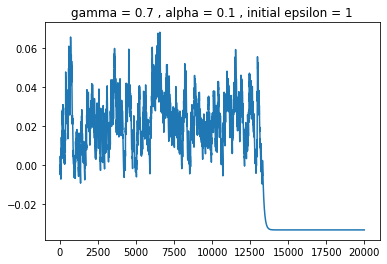

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.4 , alpha = 0.1 , initial epsilon = 1
Total training time = 0:00:25.099742


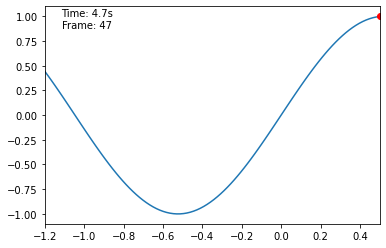

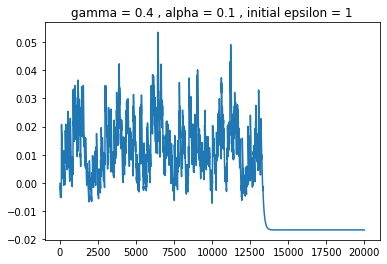

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.1 , alpha = 0.1 , initial epsilon = 1
Total training time = 0:00:20.862445


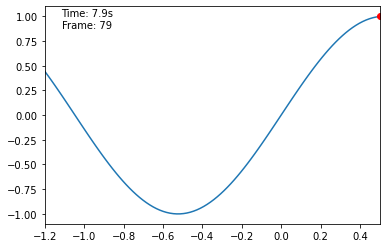

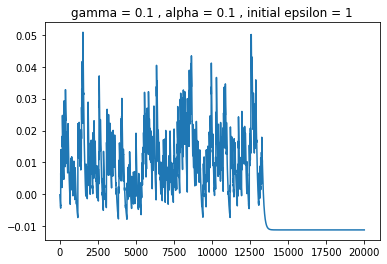

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.01 , alpha = 0.1 , initial epsilon = 1
Total training time = 0:00:26.703358


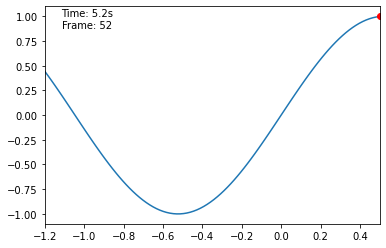

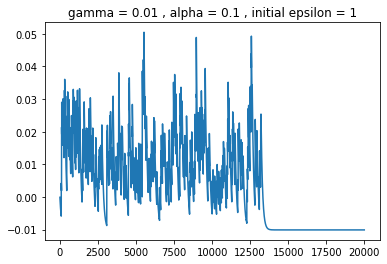

MovieWriter ffmpeg unavailable; using Pillow instead.


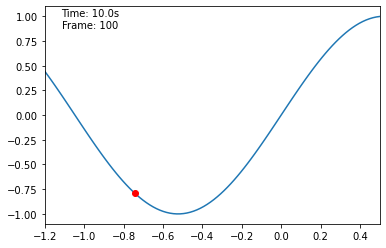

In [48]:
discount_factor = [0.7, 0.4, 0.1, 0.01]

for gamma in discount_factor:
    train(gamma)

gamma = 0.999 , alpha = 0.5 , initial epsilon = 1
Total training time = 0:00:24.489854


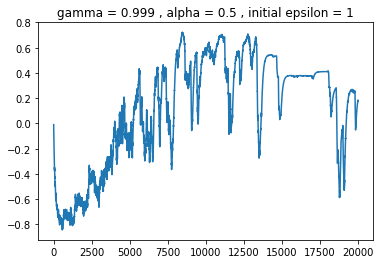

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.01 , initial epsilon = 1
Total training time = 0:00:18.849135


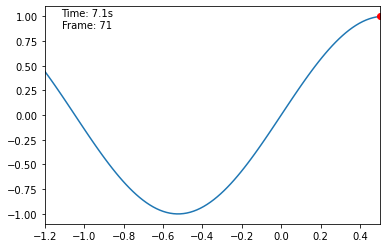

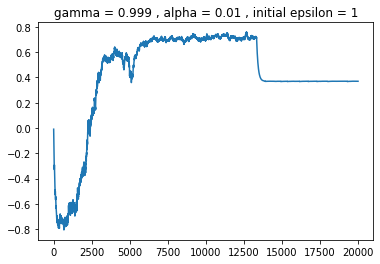

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.001 , initial epsilon = 1
Total training time = 0:00:34.323188


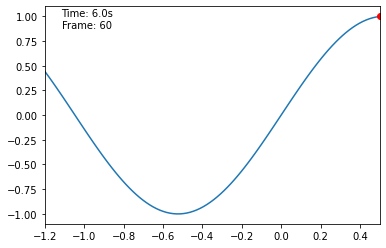

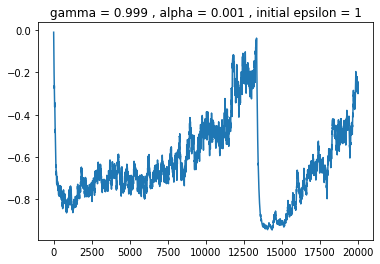

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.0001 , initial epsilon = 1
Total training time = 0:00:36.750822


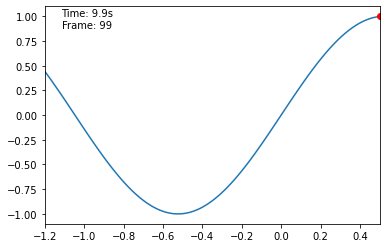

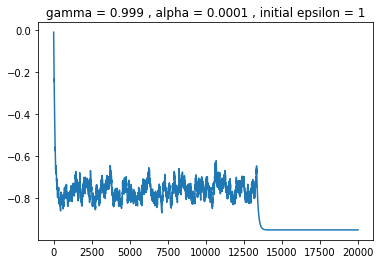

MovieWriter ffmpeg unavailable; using Pillow instead.


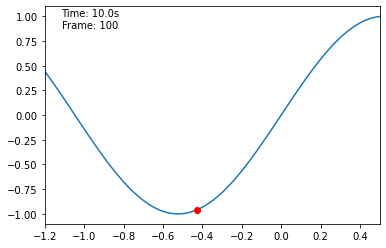

In [33]:
learning_rate = [0.5, 0.01, 0.001, 0.0001]

for alpha in learning_rate:
    train(alpha=alpha)

gamma = 0.999 , alpha = 0.1 , initial epsilon = 1
Total training time = 0:00:19.803019


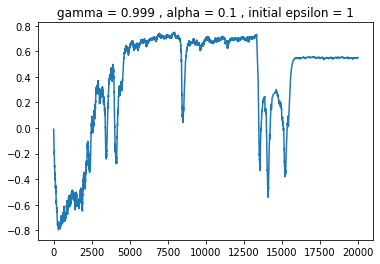

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.1 , initial epsilon = 0.1
Total training time = 0:00:14.112727


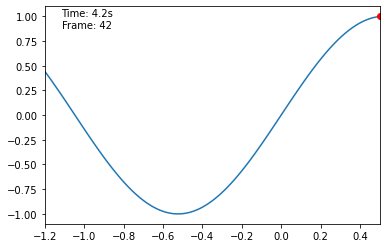

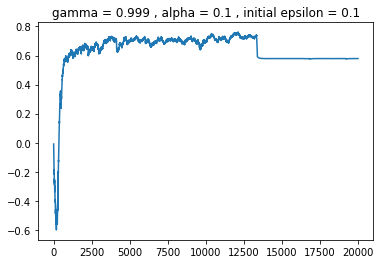

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.1 , initial epsilon = 0.01
Total training time = 0:00:17.462850


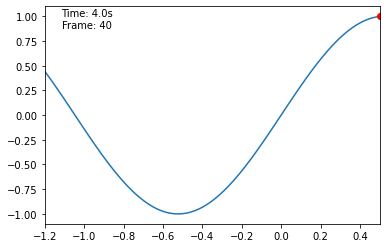

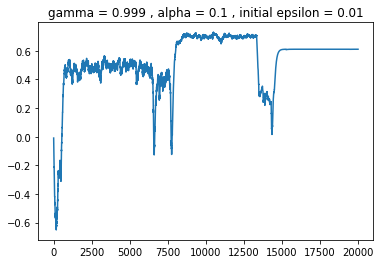

MovieWriter ffmpeg unavailable; using Pillow instead.


gamma = 0.999 , alpha = 0.1 , initial epsilon = 0.001
Total training time = 0:00:15.366997


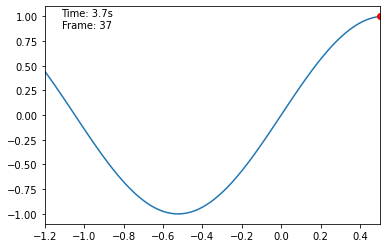

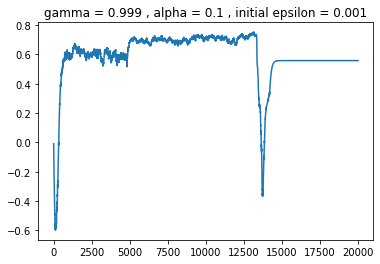

MovieWriter ffmpeg unavailable; using Pillow instead.


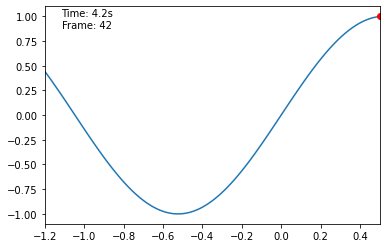

In [50]:
initial_epsilon = [1, 0.1, 0.01, 0.001]

for epsilon in initial_epsilon:
    train(epsilon_i=epsilon)